In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("hw4-dds.ipynb")

In [3]:
import numpy as np
import pandas as pd
import altair as alt
import statsmodels.api as sm
# disable row limit for plotting
alt.data_transformers.disable_max_rows()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# uncomment to ensure graphics display with pdf export
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Background: California Department of Developmental Services

From Taylor, S. A., & Mickel, A. E. (2014). Simpson's Paradox: A Data Set and Discrimination Case Study Exercise. Journal of Statistics Education, 22(1):

> Most states in the USA provide services and support to individuals with developmental disabilities (e.g., intellectual disability, cerebral palsy, autism, etc.) and their families. The agency through which the State of California serves the developmentally-disabled population is the California Department of Developmental Services (DDS) ... One of the responsibilities of DDS is to allocate funds that support over 250,000 developmentally-disabled residents. A number of years ago, an allegation of discrimination was made and supported by a univariate analysis that examined average annual expenditures on consumers by ethnicity. The analysis revealed that the average annual expenditures on Hispanic consumers was approximately one-third of the average expenditures on White non-Hispanic consumers. This finding was the catalyst for further investigation; subsequently, state legislators and department managers sought consulting services from a statistician.

In this assignment, you'll analyze the deidentified DDS data published with this article to answer the question: *is there evidence of ethnic or gender discrimination in allocation of DDS funds?* This will involve practicing the following:

* exploratory data visualization
* regression analysis
* model visualization

**Aside**: The JSE article focuses on what's known as [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), an arithmetic phenomenon in which aggregate trends across multiple groups show the *opposite* of within-group trends. We won't emphasize this topic, though the data does provide a nice illustration.

# DDS data

The data for this assignment are already tidy, so in this section you'll just familiarize yourself with basic characteristics. The first few rows of the data are shown below:

In [4]:
dds = pd.read_csv('data/california-dds.csv')
dds.head()

,Id,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,10210,13 to 17,17,Female,2113,White not Hispanic
1,10409,22 to 50,37,Male,41924,White not Hispanic
2,10486,0 to 5,3,Male,1454,Hispanic
3,10538,18 to 21,19,Female,6400,Hispanic
4,10568,13 to 17,13,Male,4412,White not Hispanic


Take a moment to open and read the data documentation (*data > california-dds-documentation.md*).

<!-- BEGIN QUESTION -->

### Question 1: Data description

Write a short paragraph answering the following questions based on the data documentation.

* (i) Why were the data collected? What is the purpose of this dataset?
* (ii) What are the observational units?
* (iii) What is the population of interest?
* (iv) How was the sample obtained (*e.g.* random sampling, adminsitrative data, convenience sampling, etc.)?
* (v) Can inferences about the population be drawn from the sample?

In addition, make a table summarizing the variables measured. Use the format below.

Name | Variable description | Type | Units of measurement
---|---|---|---
ID | Unique consumer identifier | Numeric | None 

This data was collected in order to analyze whether or not discrimination based on Race was apparent in the allocation of funds to support individuals with developmental disorders. The observational units were the individuals who recieved funds from the California Department of Developmental Services. The population of interest is all individuals in California with a developmental disorder who recieves funds from this service (more than 250,000 'consumers'). The data documentation does not say specifically what type of sampling was done to get the data other than that it is a sample of the 250,000 data points they have. I think that inferences can be drawn about the population from the sample because it is large enough to understand or get a general grasp of the population as long as it is a random sample.


In [5]:
table = pd.DataFrame(columns=['Name','Variable Description','Type','Units of Measurement'])
Names = ['ID','Age Cohort','Age','Gender','Expenditures','Ethnicity']
Variables = ['Unique Consumer Identification', 'Binned Age','Unbinned Age','Male or Female','Annual Expenditures spent on Consumer','One of Eight Ethnic group']
Type = ['Numeric','Character','Numeric','Character','Numeric','Character']
Units = ['None','Years','Years','None','Dollar Amount','None']

table['Name'] = Names
table['Variable Description'] = Variables
table['Type'] = Type
table['Units of Measurement'] = Units

table

,Name,Variable Description,Type,Units of Measurement
0,ID,Unique Consumer Identification,Numeric,None
1,Age Cohort,Binned Age,Character,Years
2,Age,Unbinned Age,Numeric,Years
3,Gender,Male or Female,Character,None
4,Expenditures,Annual Expenditures spent on Consumer,Numeric,Dollar Amount
5,Ethnicity,One of Eight Ethnic group,Character,None


<!-- END QUESTION -->

# Exploratory analysis

Here you'll use graphical and descriptive techniques to explore the allegation of discriminatory allocation of benefits.

### Question 2: Alleged discrimination

Construct a table of median expenditures by ethnicity that also shows the sample size for each ethnic group in the data.

1. Slice the ethnicity and expenditure variables from `dds`, group by ethnicity, and calculate the median expenditure. Store the resulting dataframe as `median_expend_by_eth`.
2. Compute the sample sizes for each ethnicity using `.value_counts()`: obtain a pandas series indexed by ethnicity with a single column named `n`. You'll need to use `.rename(...)` to avoid having the column named `Ethnicity`. Store this pandas series as `ethnicity_n`.
3. Use `pd.concat(...)` to append the sample sizes in `ethnicity_n` to the median expenditures in `median_expend_by_eth`. Store the result as `tbl_1`.

Print `tbl_1`. Does expenditure seem to differ by ethnicity? Does sample size?

The median expenditure does seem to differ by ethnicity and by quite a lot. The sample size also varies greatly between ethnicities.

In [6]:
# compute median expenditures
median_expend_by_eth = dds.loc[:, ['Ethnicity', 'Expenditures']].groupby('Ethnicity').median()

# compute sample sizes
ethnicity_n = dds['Ethnicity'].value_counts().rename('n')

# concatenate
tbl_1 = pd.concat([median_expend_by_eth, ethnicity_n], axis=1)

# print
tbl_1

,Expenditures,n
Ethnicity,,
American Indian,41817.5,4
Asian,9369.0,129
Black,8687.0,59
Hispanic,3952.0,376
Multi Race,2622.0,26
Native Hawaiian,40727.0,3
Other,3316.5,2
White not Hispanic,15718.0,401


In [7]:
grader.check("q2")

q2 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3: Plot median expenditures

Construct a point-and-line plot of median expenditure (y) against ethnicity (x), with:
* ethnicities sorted by descending median expenditure;
* the median expenditure axis shown on the log scale;
* the y-axis labeled 'Median expenditure'; and 
* no x-axis label (since the ethnicity group names are used to label the axis ticks, the label 'Ethnicity' is redundant). 

Store the result as `fig_1` and display the plot.

*Hints*:
* you'll need to use `tbl_1.reset_index()` to obtain the ethnicity group as a variable;
* recall that `.mark_line(point = True)` will add points to a line plot;
* sorting can be done using `alt.X(..., sort = alt.EncodingSortField(field = ..., order = ...))`

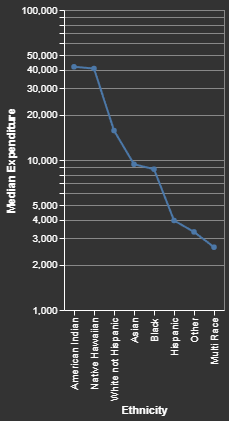

In [8]:
fig_1 = alt.Chart(tbl_1.reset_index()).mark_line(point=True).encode(
    x = alt.X('Ethnicity:N', sort = alt.EncodingSortField(field = 'Expenditures', order = 'descending')),
    y = alt.Y('Expenditures:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title='Median Expenditure'))
)

fig_1

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4: Age and expenditure

How does expenditure differ by age? Construct a scatterplot of expenditure against age. Store the plot as `fig_2`. In one or two sentences, comment on the plot -- what is the main pattern it reveals?

The main pattern that this plot reveals is that the older the person is, the more the expenditures on that person is on average. We can see that the expenditures drastically increase from people under 20 to people over 20.

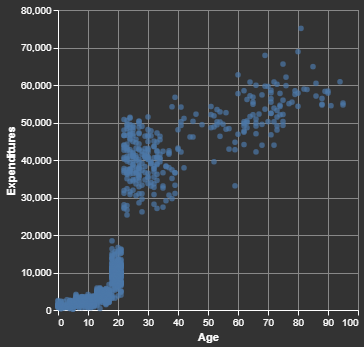

In [9]:
# construct scatterplot
fig_2 = alt.Chart(dds).mark_circle().encode(
    x = alt.X('Age:Q'),
    y = alt.Y('Expenditures:Q')
)

# display
fig_2

<!-- END QUESTION -->

Precisely because recipients have different needs at different ages that translate to jumps in expenditure, age has been discretized into age cohorts defined based on need level. Going forward, we'll work with these age cohorts -- by treating age as discrete, we won't need to attempt to model the discontinuities in the relationship between age and expenditure.

The cohort labels are stored as `Age Cohort` in the dataset. There are six cohorts; the cell below coerces the labels to an ordered category, puts them in the proper order, and prints the category levels.

In [10]:
# convert data types
dds_cat = dds.astype({'Age Cohort': 'category', 'Ethnicity': 'category', 'Gender': 'category'}).copy()

dds_cat['Age Cohort'] = dds_cat['Age Cohort'].cat.as_ordered().cat.reorder_categories(
    dds_cat['Age Cohort'].cat.categories[[0, 5, 1, 2, 3, 4]]
)

# age cohorts
dds_cat['Age Cohort'].cat.categories

Index(['0 to 5', '6 to 12', '13 to 17', '18 to 21', '22 to 50', '51+'], dtype='object')

Here is an explanation of how the cohort age boundaries were chosen:

> The 0-5 cohort (preschool age) has the fewest needs and requires the least amount of funding. For the 6-12 cohort (elementary school age) and 13-17 (high school age), a number of needed services are provided by schools. The 18-21 cohort is typically in a transition phase as the consumers begin moving out from their parents’ homes into community centers or living on their own. The majority of those in the 22-50 cohort no longer live with their parents but may still receive some support from their family. Those in the 51+ cohort have the most needs and require the most amount of funding because they are living on their own or in community centers and often have no living parents.

Note that the ordering can be retrieved using `.cat.codes`, which coerces an ordered categorical variable to its integer encoding (0 for lowest level, 1 for next lowest, and so on). It will be helpful to store the ordering for plotting purposes.

In [11]:
# retrieve ordering
dds_cat['cohort_order'] = dds_cat['Age Cohort'].cat.codes.head()
dds_cat.head()

,Id,Age Cohort,Age,Gender,Expenditures,Ethnicity,cohort_order
0,10210,13 to 17,17,Female,2113,White not Hispanic,2.0
1,10409,22 to 50,37,Male,41924,White not Hispanic,4.0
2,10486,0 to 5,3,Male,1454,Hispanic,0.0
3,10538,18 to 21,19,Female,6400,Hispanic,3.0
4,10568,13 to 17,13,Male,4412,White not Hispanic,2.0


<!-- BEGIN QUESTION -->

### Question 5: age structure of the sample

Here you'll explore the age composition of each ethnic group in the sample.

* (i) Group the data by ethnic group and tabulate the sample sizes for each group. Use `dds_cat` so that the order of age cohorts is preserved. Store the result as `samp_sizes`.

* (ii) Visualize the age structure of each ethnic group in the sample. Construct a point-and-line plot of the sample size (y) against age cohort (x) by ethnicity (color or linetype). Make sure to preserve the ordering of age cohorts on the x axis (*hint*: create a variable like `cohort_order` above). Store the plot as `fig_3` and display.

Comment on the figure. Are there differences in age composition by ethnic group among the individuals sampled?

From the graph, we can see that there are certainly differences in age composition by ethnic group. Hispanics have more people under the age of 22 than any other ethnicity and Whites have more people older than 22 than any other ethnicity.

In [13]:
# compute sample sizes for each age/ethnic group
samp_sizes = dds_cat.groupby(
    ['Ethnicity', 'Age Cohort']
).Id.count().reset_index().rename(
    columns = {'Id':'Sample Size'}
)
cohort_order = samp_sizes['Age Cohort'].cat.categories.tolist()


# construct plot
fig_3 = alt.Chart(samp_sizes).mark_line(point=True).encode(
    x = alt.X('Age Cohort:N', sort = cohort_order),
    y = alt.Y('Sample Size:Q'),
    color = alt.Color('Ethnicity')
)

# display
fig_3

['0 to 5', '6 to 12', '13 to 17', '18 to 21', '22 to 50', '51+']

<!-- END QUESTION -->

Age structure among ethnic groups might be related to the observed differences in median expenditure, because we know that:

* (i) among the individuals in the sample, age distributions differed by ethnic group
* (ii) age is related to benefit expenditure

To see this, think through an example.

<!-- BEGIN QUESTION -->

### Question 6: potential confounding

Look at the age distribution for `Multi Race` and consider the age-expenditure relationship. Can you explain why the median expenditure for this group might be lower than the others? Answer in 1-2 sentences.

Looking at Multi Race, the first thing that we notice is that the majority of people in this sample are under the age of 20, which means that the median expenditure is guaranteed to be an observation from a person below the age of 20. We know that age has a positive relationship with expenditure so the median for multi race is likely to be lower than other ethnicities that may have a more even spread of people in the age cohorts.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7: correcting for age

Hopefully, the last few prompts convinced you that the apparent discrimination *could* simply be an artefact of differing age structure. You can investigate this by plotting median expenditure against ethnicity, as in figure 1, but now also correcting for age cohort.

Construct an Altair point-and-line chart based on `dds_cat` with:

   + ethnicity on the x axis
   + no x axis label
   + median expenditure on the y axis
   + the y axis displayed on the log scale
   + age cohort mapped to color and sorted in order of age
   + lines connecting points that display the median expenditure for each ethnicity and cohort, with one line per age cohort
    
Store the result as `fig_4` and display the graphic.

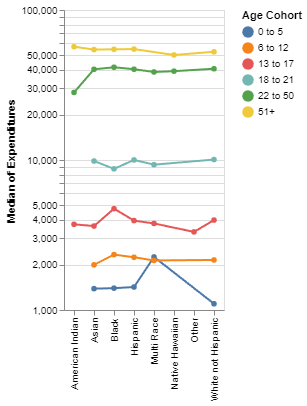

In [12]:
# construct plot
fig_4 = alt.Chart(dds_cat).mark_line(point=True).encode(
    x = alt.X('Ethnicity:N', title=None),
    y = alt.Y('median(Expenditures):Q', scale = alt.Scale(type = 'log')),
    color = alt.Color('Age Cohort:N', sort = cohort_order)
)

# display
fig_4

<!-- END QUESTION -->

# Regression analysis

Now that you've thoroughly explored the data, you'll use a linear model in this part to estimate the differences in median expenditure that you observed graphically in part 1.

More specifically, you'll model the log of expenditures (response variable) as a function of gender, age cohort, and ethnicity:

$$
\log\left(\text{expend}_i\right)
    = \beta_0 + \underbrace{\beta_1\left(\text{6-12}\right)_i + \cdots + \beta_5\left(\text{51+}\right)_i}_\text{age cohort} + \underbrace{\beta_6\text{female}_i}_\text{sex} + \underbrace{\beta_7\text{hispanic}_i + \cdots + \beta_{13}\text{other}_i}_\text{ethnicity} + \epsilon_i
$$

In this model, *all* of the explanatory variables are categorical and encoded using indicators; in this case, the linear model coefficients capture means for each group. 

Because this model is a little different than the examples you've seen so far in two respects -- the response variable is log-transformed and all explanatory variables are categorical -- some comments are provided below on these features. You can review or skip the comments, depending on your level of interest in understanding the model better mathematically.

**Commments about parameter interpretation**

In particular, each coefficient represents a difference in means from the 'baseline' group. All indicators are zero for a white male recipient between ages 0 and 5, so this is the baseline group and:

$$\mathbb{E}\left(\log(\text{expend})\;|\; \text{male, white, 0-5}\right) = \beta_1$$

Then, the expected log expenditure for a hispanic male recipient between ages 0 and 5 is:

$$\mathbb{E}\left(\log(\text{expend})\;|\; \text{male, hispanic, 0-5}\right) = \beta_0 + \beta_7$$

So $\beta_7$ is *the difference in mean log expenditure between hispanic and white recipients after accounting for gender and age*. The other parameters have similar interpretations.

While the calculation shown above may seem a little foreign, you should know that the parameters represent marginal differences in means between genders (holding age and ethnicity fixed), between ages (holding gender and ethnicity fixed), and between ethnicities (holding age and gender fixed).

**Comments about the log transformation**

The response in this model is the *log* of expenditures (this gives a better model for a variety of reasons). The statistical assumption then becomes that:

$$\log(\text{expend})_i \sim N\left(\mathbf{x}_i'\beta, \sigma^2\right)$$

If the log of a random variable $Y$ is normal, then $Y$ is known as a *lognormal* random variable; it can be shown mathematically that the exponentiated mean of $\log Y$ is the median of $Y$. As a consequence, according to our model:

$$\text{median}(\text{expend}_i) = \exp\left\{\mathbf{x}_i'\beta\right\}$$

You'll work on the log scale throughout to avoid complicating matters, but know that this model for the log of expenditures is *equivalently* a model of the median expenditures.

The cell below reorders the category levels to match the model written above. To ensure the parameters appear in the proper order, this reordering is done for you.

In [13]:
# remove ID and quantitative age
reg_data = dds_cat.copy().drop(columns = ['Id', 'Age'])

# reorder ethnicity
reg_data['Ethnicity'] = reg_data.Ethnicity.cat.as_ordered().cat.reorder_categories(
    reg_data.Ethnicity.cat.categories[[7, 3, 2, 1, 5, 0, 4, 6]]
)

# reorder gender
reg_data['Gender'] = reg_data.Gender.cat.as_ordered().cat.reorder_categories(['Male', 'Female'])
reg_data

,Age Cohort,Gender,Expenditures,Ethnicity,cohort_order
0,13 to 17,Female,2113,White not Hispanic,2.0
1,22 to 50,Male,41924,White not Hispanic,4.0
2,0 to 5,Male,1454,Hispanic,0.0
3,18 to 21,Female,6400,Hispanic,3.0
4,13 to 17,Male,4412,White not Hispanic,2.0
...,...,...,...,...,...
995,51+,Female,57055,White not Hispanic,NaN
996,18 to 21,Male,7494,Hispanic,NaN
997,13 to 17,Female,3673,Multi Race,NaN
998,6 to 12,Male,3638,Hispanic,NaN


### Question 8: Data preprocessing

Obtain the explanatory variable matrix and response vector needed to fit the linear model.

1. Use `pd.get_dummies(..., drop_first = True)` to create the indicator variable encodings for gender, ethnicity, and age. Note that this function can process multiple categorical variables at once. Store the data frame of indicators for all three variables as `indicators`.
2. Add an intercept to obtain the explanatory variable matrix. Store this as a data frame called `x`.
3. Store the response variable as a pandas series named `y`.

In [14]:
indicators = pd.get_dummies(reg_data[['Gender', 'Ethnicity', 'Age Cohort']], drop_first = True).astype(int)
x = sm.tools.add_constant(indicators)
y = np.log(reg_data['Expenditures'])

In [15]:
grader.check("q8")

q8 results: All test cases passed!

### Question 9: model fitting

Fit the model:

$$
\log\left(\text{expend}_i\right)
    = \beta_0 + \beta_1\left(\text{6-12}\right)_i + \cdots + \beta_5\left(\text{51+}\right)_i 
        + \beta_6\text{female}_i 
        + \beta_7\text{hispanic}_i + \cdots + \beta_{13}\text{other}_i
        + \epsilon_i
$$

Store the parameter estimates and standard errors as a data frame named `coef_tbl`. Index the data frame by variable name, and don't forget to include the error variance estimate. Display the result.

In [16]:
# fit model
mlr = sm.OLS(y, x)
rslt = mlr.fit()

# retreive estimates and std errors
coef_tbl = pd.DataFrame(
    {'estimate': rslt.params.values,
    'standard error': np.sqrt(rslt.cov_params().values.diagonal())},
    index = x.columns)
coef_tbl.loc['error variance', 'estimate'] = rslt.scale

# display
coef_tbl

,estimate,standard error
const,7.092439,0.041661
Gender_Female,0.039784,0.020749
Ethnicity_Hispanic,0.038594,0.024893
Ethnicity_Black,0.041713,0.045725
Ethnicity_Asian,-0.021103,0.033470
Ethnicity_Native Hawaiian,-0.030725,0.189967
Ethnicity_American Indian,-0.054396,0.164910
Ethnicity_Multi Race,0.041024,0.067680
Ethnicity_Other,-0.189877,0.232910
Age Cohort_6 to 12,0.490276,0.043855


In [17]:
grader.check("q9")

q9 results: All test cases passed!

Now look at both the estimates and standard errors for each level of each categorical variable; if some estimates are large for at least one level and the standard errors aren't too big, then estimated mean log expenditures differ according to the value of that variable when the other variables are held constant.

For example: the estimate for `Gender_Female` is 0.04; that means that, if age and ethnicity are held fixed, the estimated difference in mean log expenditure between female and male recipients is 0.04. If $\log(a) - \log(b) = 0.04$, then $\frac{a}{b} = e^{0.04} \approx 1.041$; so the estimated expenditures (not on the log scale) differ by a factor of about 1, *i.e.*, are about the same. Further, the standard error is 0.02, so the estimate is within 2SE of 0; the difference could well be zero. So the model suggests there is no difference in expenditure by gender.

<!-- BEGIN QUESTION -->

### Question 10: interpretation

Do the parameter estimates suggest differences in expenditure by age or ethnicity?

First consider the estimates and standard errors for each level of age, and state whether any differences in mean log expenditure between levels appear significant; if so, cite one example. Then do the same for the levels of ethnicity. Answer in 2-4 sentences.

(*Hint*: it may be helpful scratch work to exponentiate the coefficient estimates and consider whether they differ by much from 1.)

The parameter estimates do not suggest differences in expenditure by ethnicity but they do by age. All exponentiated estimates for ethnicity are very close to 1 meaning the estimated expenditures are about the same between ethnicities. On the other hand, for age, the estimates increase exponentially the higher the age cohort is.

In [18]:
# exponentiate parameter estimates
coef_tbl['exp_estimates'] = np.exp(coef_tbl['estimate'])
coef_tbl

,estimate,standard error,exp_estimates
const,7.092439,0.041661,1202.838256
Gender_Female,0.039784,0.020749,1.040586
Ethnicity_Hispanic,0.038594,0.024893,1.039348
Ethnicity_Black,0.041713,0.045725,1.042595
Ethnicity_Asian,-0.021103,0.033470,0.979118
Ethnicity_Native Hawaiian,-0.030725,0.189967,0.969742
Ethnicity_American Indian,-0.054396,0.164910,0.947057
Ethnicity_Multi Race,0.041024,0.067680,1.041877
Ethnicity_Other,-0.189877,0.232910,0.827061
Age Cohort_6 to 12,0.490276,0.043855,1.632767


<!-- END QUESTION -->

Now as a final step in the analysis, you'll visualize your results. The idea is simple: plot the estimated mean log expenditures for each group. Essentially you'll make a version of your figure 4 from part 1 in which the points are estimated rather than observed. So the model visualization graphic will look similar to your exploratory figure.

The cell below constructs a prediction grid for you. This grid comprises all unique combinations of the age, sex, and ethnicity categories.

In [19]:
# obtain unique values of each categorical variable
genders = reg_data.Gender.cat.categories.values
ethnicities = reg_data.Ethnicity.cat.categories.values
ages = reg_data['Age Cohort'].cat.categories.values

# generate mesh
gx, ex, ax = np.meshgrid(genders, ethnicities, ages)
grid = np.array([gx.ravel(), ex.ravel(), ax.ravel()]).T

# coerce to dataframe
grid_df = pd.DataFrame(grid, columns = ['Gender', 'Ethnicity', 'Age Cohort'])
grid_df.head()
grid_df['Ethnicity'].unique()

array(['White not Hispanic', 'Hispanic', 'Black', 'Asian',
       'Native Hawaiian', 'American Indian', 'Multi Race', 'Other'],
      dtype=object)

### Question 11: compute predictions

Calculate predictions with confidence intervals for the predicted mean for each grid point; append these to `grid_df` and store the result as `pred_df`. Ensure that the column containing the predictions is named `mean`.

Note that you will need to generate indicators in order to compute the predictions; this can be done in the same way that the data were preprocessed. Note also that **you will need to arrange the indicator columns in exactly the same order that they appear in the explanatory variable matrix** in order to generate valid predictions.

In [20]:
#generate indicators based on the prediction grid
grid_indicators = pd.get_dummies(grid_df[['Gender','Ethnicity','Age Cohort']]).astype(int)

#add an intercept and arrange columns to match x
x_grid = sm.tools.add_constant(grid_indicators)
x_grid = x_grid[x.columns]

#compute predictions

preds = rslt.get_prediction(x_grid) 

#append values of categorical variables at grid points to predictions
pred_df = pd.concat([grid_df, preds.summary_frame()], axis=1)

#preview
pred_df.head()

,Gender,Ethnicity,Age Cohort,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,Male,White not Hispanic,0 to 5,7.092439,0.041661,7.010685,7.174194,6.445331,7.739548
1,Male,White not Hispanic,6 to 12,7.582715,0.032020,7.519881,7.645550,6.937724,8.227707
2,Male,White not Hispanic,13 to 17,8.193450,0.029301,8.135950,8.250950,7.548956,8.837943
3,Male,White not Hispanic,18 to 21,9.116283,0.029439,9.058513,9.174053,8.471765,9.760801
4,Male,White not Hispanic,22 to 50,10.563276,0.025658,10.512926,10.613626,9.919380,11.207171


In [21]:
grader.check("q11")

q11 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 12: model visualization

Plot estimated mean log expenditure (y) against ethnicity (x) by age cohort (color) and gender (facet). Construct a line plot with points at each estimated value, and include confidence bands. Use a sequential color scale for age and ensure that the age cohorts are in appropriate order (you may want to construct another `cohort_order` variable as before for this purpose).

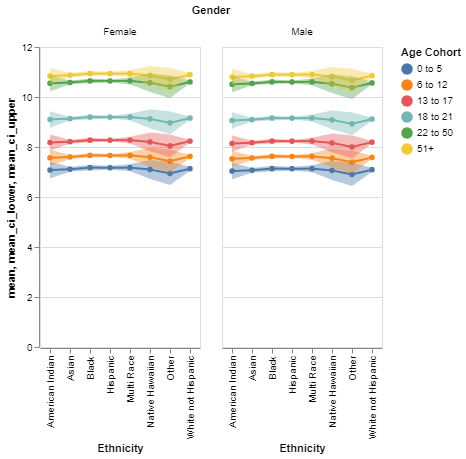

In [22]:
# add cohort ordering
pred_cat = pred_df.astype({'Age Cohort': 'category', 'Ethnicity': 'category', 'Gender': 'category'}).copy()
pred_cat['Age Cohort'] = pred_cat['Age Cohort'].cat.as_ordered().cat.reorder_categories(
    pred_cat["Age Cohort"].cat.categories[[0, 5, 1, 2, 3, 4]]
)

pred_cat['cohort_order'] = pred_cat['Age Cohort'].cat.codes

cohort_order = pred_cat['Age Cohort'].cat.categories.tolist()

# construct point-and-line plot
lines = alt.Chart(pred_cat).mark_line(point = True).encode(
    x = 'Ethnicity:N',
    y = 'mean:Q',
    color = alt.Color('Age Cohort:N', sort = cohort_order)
)

# construct confidence bands
bands = alt.Chart(pred_cat).mark_area(opacity = 0.4).encode(
    x = 'Ethnicity:N',
    y = 'mean_ci_lower:Q',
    y2 = 'mean_ci_upper:Q',
    color = alt.Color('Age Cohort:N', sort = cohort_order)
)

# layer then facet
fig_5 = (lines + bands).facet('Gender:N')

# display
fig_5

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 13: uncertainty

Which estimates have greater uncertainty and why? Identify the ethnic groups for which the uncertainty band is relatively wide in the plot. Why might uncertainty be higher for these groups? Answer in 2 sentences.

(*Hint*: it may help to refer to figure 3.)

From the confidence intervals in figure 5, we can see that the Native Hawaiian, Other, and American Indian ethnicities have the greatest uncertainty for the estimation. This is due to the fact that there is a much smaller sample size for these ethnicities and there is not enough data to be more accurate.

<!-- END QUESTION -->

# Communicating results

Review your exploratory and regression analyses above, and then answer the following questions.

<!-- BEGIN QUESTION -->

### Question 14: summary

Write a one-paragraph summary of your analysis. Focus on answering the question, 'do the data provide evidence of ethnic or gender discrimination in allocation of DDS funds?'

Your summary should include the following:

* a description of the data indicating observations, variables, and sampling mechanism;
* a description of any important exploratory findings;
* a description of the method you used to analyze the data (don't worry about capturing every detail);
* a description of the findings of the analysis;
* an answer to the question.

After visualizing all the data into simple graphs and looking at estimations on this topic, I can conclude that the data does not provide any evidence of ethnic or gender discrimination in the allocation of DDS funds. From figure 1, it appears as though the median allocation of funds is affected by the ethnicity of the individual but figures 2 and 4 work together to show that the reason for the differences is actually based on the age of the individual rather than ethnicity. Figure 4 shows a fairly even median of expenditures between ethnicities accounting for the age. As we see with figure 3, ethnicities such as White have a much higher ratio of older to younger individuals which will result in a higher median of expenditures. By using linear regression and estimation, I found that there is no evidence to support that expenditure is affected by ethnicity and Gender but only by Age. We can also see this in figure 5 where I make two plots of the mean estimated expenditure by ethnicity and age cohort the individual and separate the plots by gender. From this figure, we can see that the estimations between ethnicity and gender are extremely similar and the only visible differences is due to the Age.

<!-- END QUESTION -->

# Submission


1. Save the notebook. 
2. Restart the kernel and run all cells. (**CAUTION**: if your notebook is not saved, you will lose your work.)
3. Carefully look through your notebook and verify that all computations execute correctly and all graphics are displayed clearly. You should see **no errors**; if there are any errors, make sure to correct them before you submit the notebook.
4. Download the notebook as an `.ipynb` file. This is your backup copy.
5. Export the notebook as PDF and upload to Gradescope.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [23]:
grader.check_all()

q11 results: All test cases passed!

q2 results: All test cases passed!

q8 results: All test cases passed!

q9 results: All test cases passed!